<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Effects of screen size and grid interval size on Component Localization Accuracy

As seen in the image below, images of electrical circuits are scaled, and a axis is added for reference before component detection. From this image, the Multi-modal LLM outputs the location of the circuit components & classification for each component.

The goal of this experimaent is to play with screen size and interval size to reveal its effect on component detection accuracy.

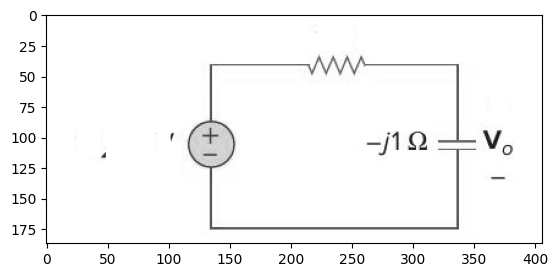

The following is an outpuit from the llm detecting components in a circuit




In [ ]:
components=[
    Component(
        position=ComponentPosition(x=2, y=5),
        component_name=<ComponentName.VOLTAGE_SOURCE: 'voltage source'>
    ),
    Component(
        position=ComponentPosition(x=5, y=5),
        component_name=<ComponentName.INDUCTOR: 'inductor'>
    ),
    Component(
        position=ComponentPosition(x=8, y=5),
        component_name=<ComponentName.CAPACITOR: 'capacitor'>
    ),
]

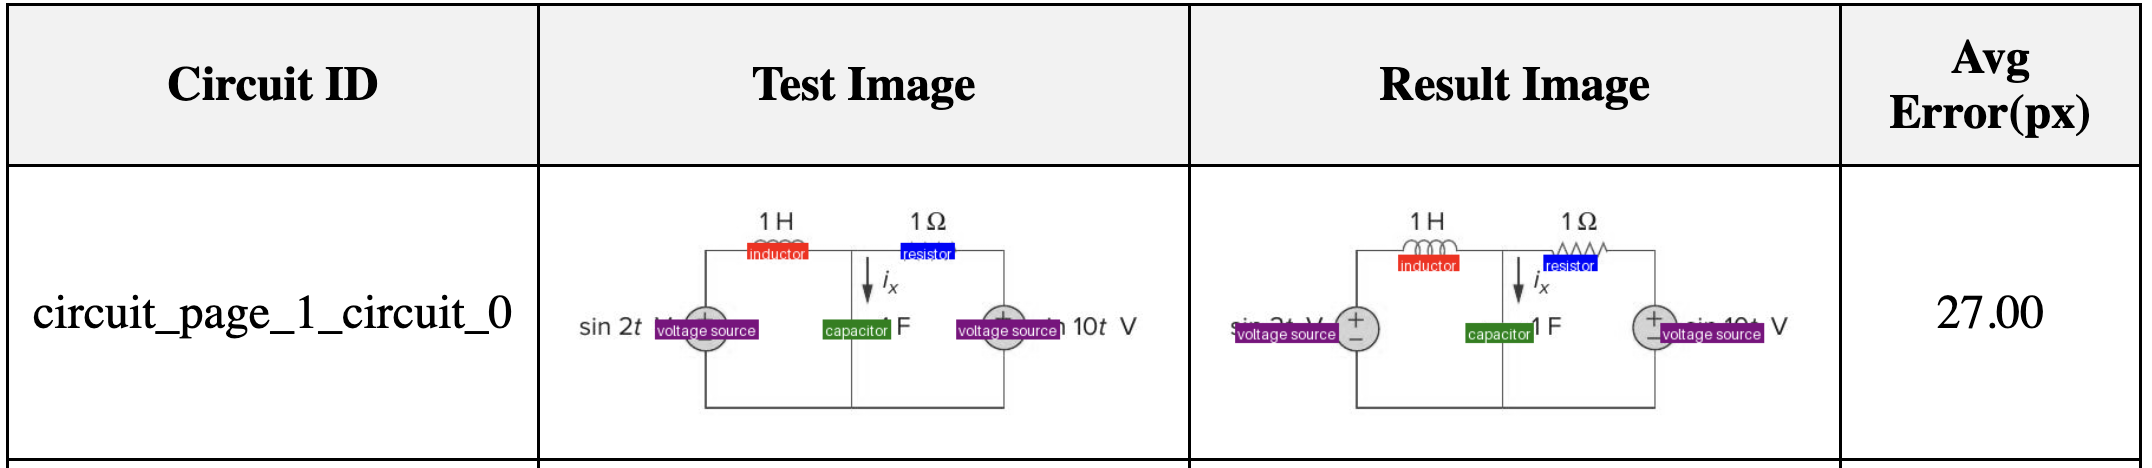

## Error Heuristic

$$Error = \frac{1}{S n} \sum_{k=0}^{n-1}{ \begin{cases} C_{name} \in \{ {x_{name} | x \in \Psi \} } : & min \{ \sqrt{||C_{pos} - G_{k,pos}||} \, \Big| \, C_{name} = G_{k,name}, C \in \Psi \} \\
\text{otherwise} : & \infty
\end{cases} }$$

$ $

$Error$ = error in component detection (% of image)

$S$ = max{width of image, height of image} (px)

$n$ = total predicted components

$\Psi$ = Ground Truth components

$G_{k}$ = kth predicted component


As seen in the formula above, the error in a component prediction works out to a average of distances to ground truth component locations. This result is also scaled by $1/S$ to make the error independent of circuit image size and unitless.

Notice that if the llm predicts a component not in the image. For example, the llm predicting a current source in the first image above, the resulting error according to this heuristic would be $\infty$

<ipython-input-18-565787f7f634>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100


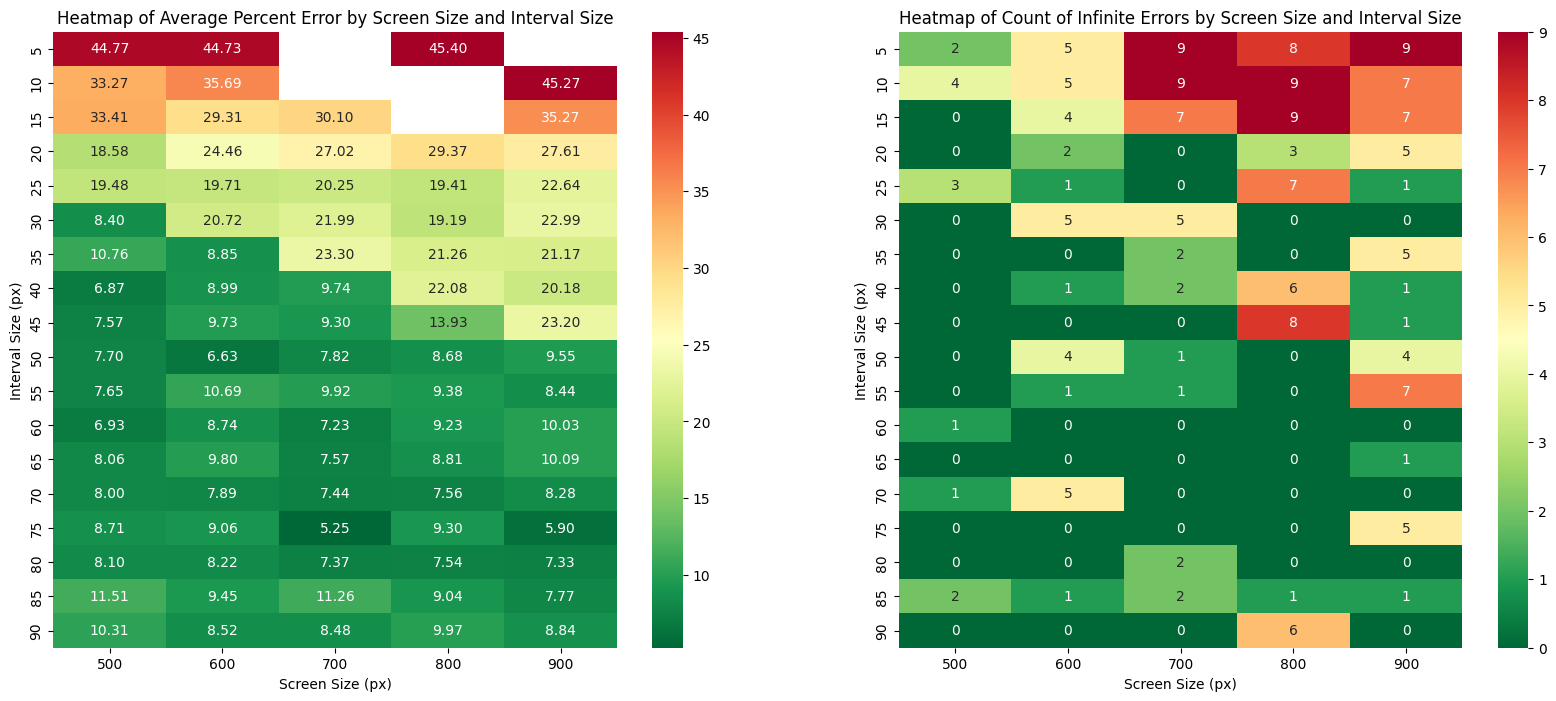

In [ ]:
import pandas as pd

# Read the data from the CSV file
file_path='/content/drive/MyDrive/Photo_Circuit/data/data_analysis/screen_sizes_intv_spacing.csv'

# Read the data from the CSV file
data = pd.read_csv(file_path)

# Remove rows where Average Error is infinity for the first heatmap
filtered_data = data[data['Average Error (px)'] != float('inf')]

# Create a new column for Average Percent Error
filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100

# Calculate the mean Average Percent Error for each combination of Screen Size and Interval Size
pivot_table_percent_error = filtered_data.pivot_table(values='Average Percent Error (%)', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='mean')

# Calculate the total count of infinite Average Error for each combination of Screen Size and Interval Size
data['inf_count'] = data['Average Error (px)'].apply(lambda x: 1 if x == float('inf') else 0)
pivot_table_inf_count = data.pivot_table(values='inf_count', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='sum')

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmaps side by side with linear color maps
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define a linear color map for percent error
cmap_linear = 'RdYlGn_r'

# First heatmap: Average Percent Error with linear color map
sns.heatmap(pivot_table_percent_error, annot=True, cmap=cmap_linear, fmt=".2f", ax=axes[0])
axes[0].set_title('Heatmap of Average Percent Error by Screen Size and Interval Size')

# Define a linear color map for infinite errors
cmap_linear_inf = 'RdYlGn_r'

# Second heatmap: Count of Infinite Errors with linear color map
sns.heatmap(pivot_table_inf_count, annot=True, cmap=cmap_linear_inf, fmt="d", ax=axes[1])
axes[1].set_title('Heatmap of Count of Infinite Errors by Screen Size and Interval Size')

plt.show()
